# Курсовой проект

## Задание

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

##### Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных

#### Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма , которую предстоит еще выплатить)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг (ежемесячная сумма к выплате)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [683]:
import math

### Загрузка библиотек

In [684]:
import pandas as pd
import numpy as np
from pathlib import Path
import math
import random

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#import xgboost as xgb
#import lightgbm as lgbm
#import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import random

import warnings
warnings.filterwarnings('ignore')

### Пути к директориям и файлам

In [685]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [686]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [687]:
df_train.shape

(7500, 17)

In [688]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [689]:
df_test.shape

(2500, 16)

In [690]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Оптимизация занимаемой памяти

In [691]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [692]:
df_train = optimizing_df(df_train)
df_test = optimizing_df(df_test)

### Типы данных

In [693]:
df_train.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                     uint8
dtype: object

## Изучение признаков -  Feature Exploring  

#### Выделение признакового описания и целевой переменной

In [694]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Bankruptcies', 'Months since last delinquent',
                    'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership', 'Years in current job', 
                    'Purpose', 'Term' ]

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Credit Score', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Debt']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Bankruptcies']

### Целевая переменная - Credit Default

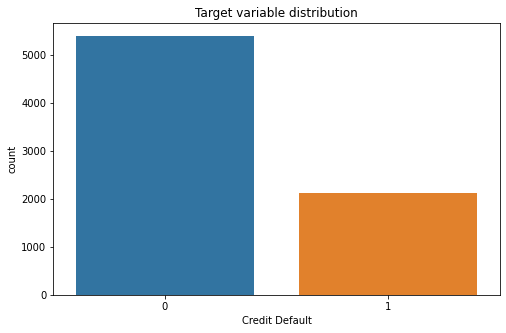

In [695]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

In [696]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Очевидна разбалансировка классов, которую необходимо будет выровнять**

In [697]:
df_train['Purpose'].dtype

CategoricalDtype(categories=['business loan', 'buy a car', 'buy house',
                  'debt consolidation', 'educational expenses',
                  'home improvements', 'major purchase', 'medical bills',
                  'moving', 'other', 'renewable energy', 'small business',
                  'take a trip', 'vacation', 'wedding'],
, ordered=False)

### Матрица корреляций

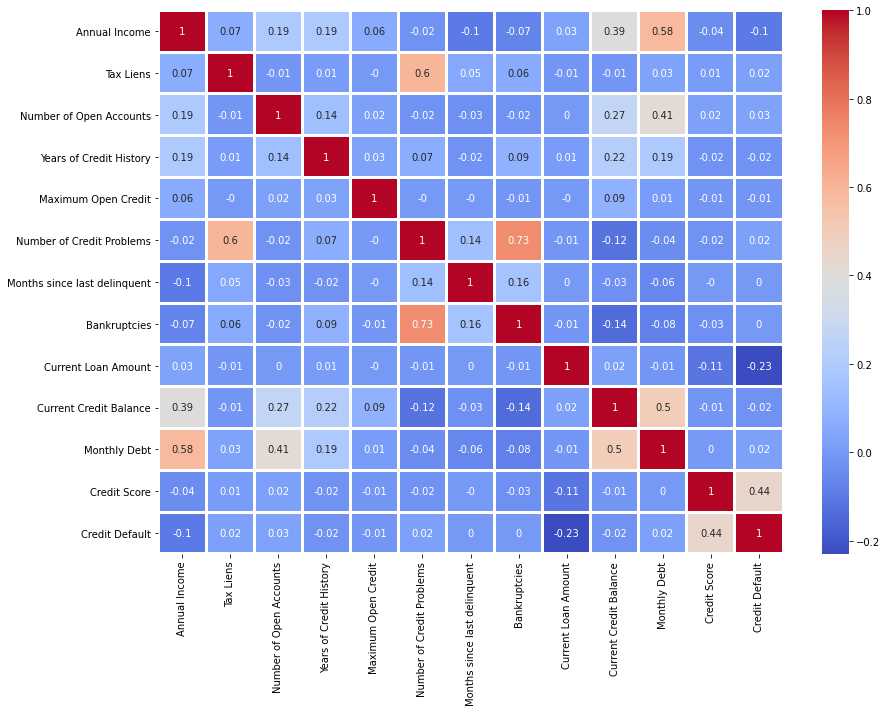

In [698]:
corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix,2)
plt.figure(figsize = (14,10))
sns.heatmap(corr_matrix, annot=True, linewidth = 2, cmap = 'coolwarm')
plt.show()

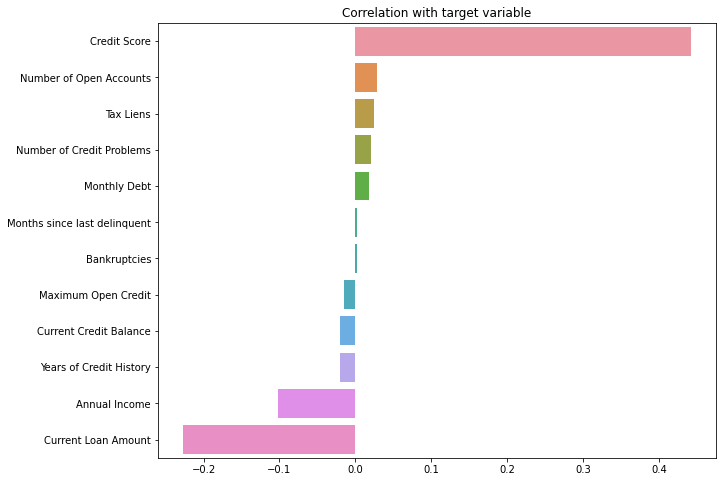

In [699]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

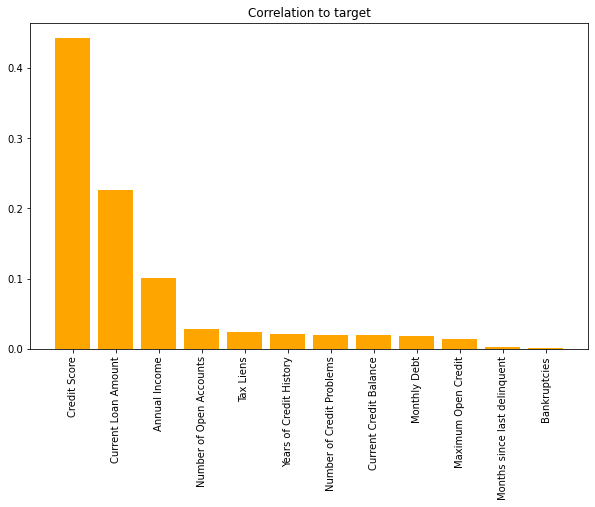

In [700]:
corr_matrix = df_train.corrwith(df_train['Credit Default'])
corr_matrix = df_train.loc[:, df_train.columns != 'Credit Default'].corrwith(df_train['Credit Default']).abs().sort_values(ascending=False)
plt.figure(figsize = (10, 6))
plt.bar(corr_matrix.index, corr_matrix.values, color = 'orange')
plt.title('Correlation to target')
plt.xticks(rotation='vertical')
plt.show()

### Изучение  признаков

In [701]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [702]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Признаки, содержащие пропуски - **Annual Income, Months since last delinquent, Years in current job, Bankruptcies, Credit Score**

### Вещественные признаки

Annual Income


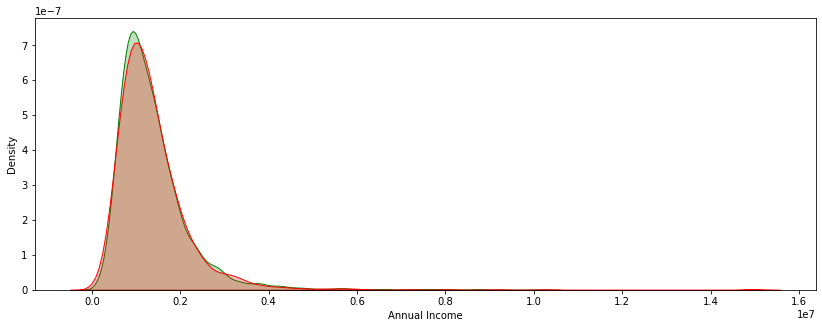

Tax Liens


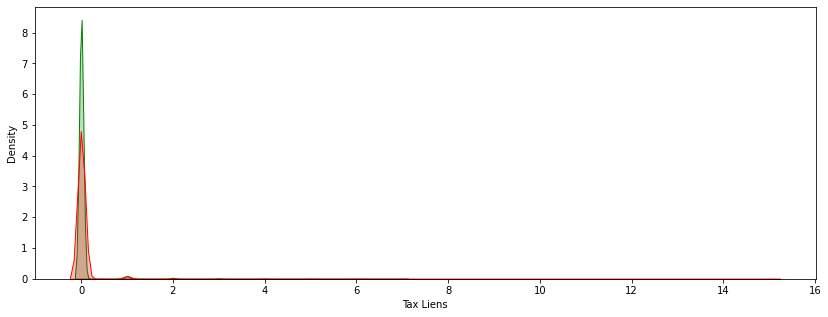

Number of Open Accounts


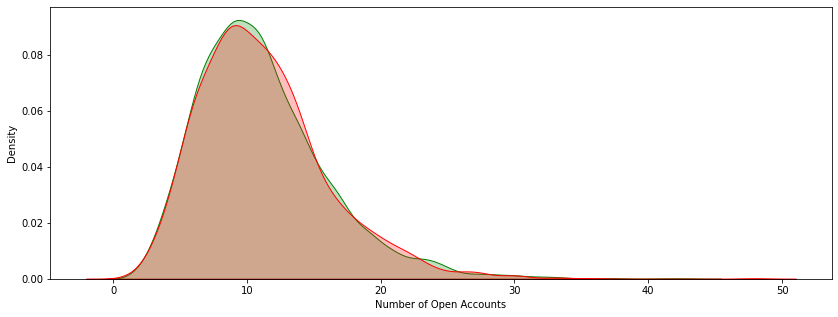

Years of Credit History


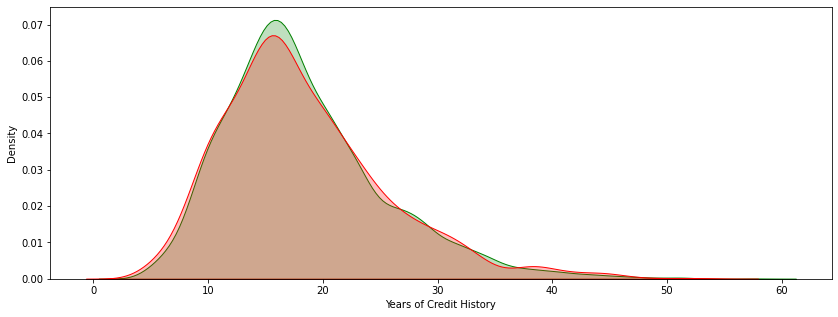

Maximum Open Credit


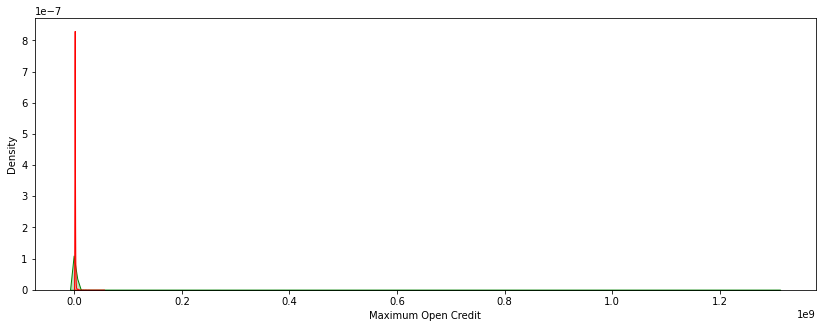

Number of Credit Problems


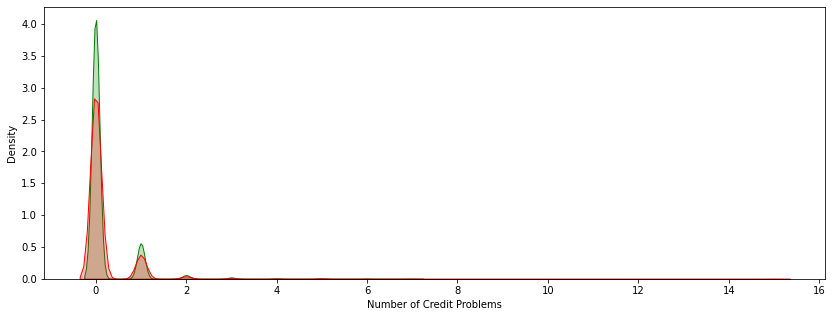

Current Loan Amount


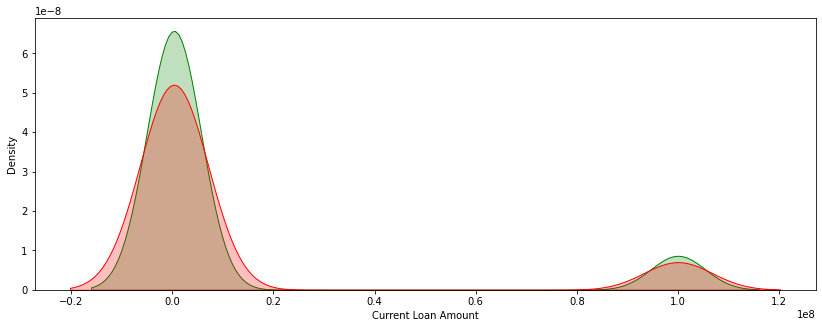

Credit Score


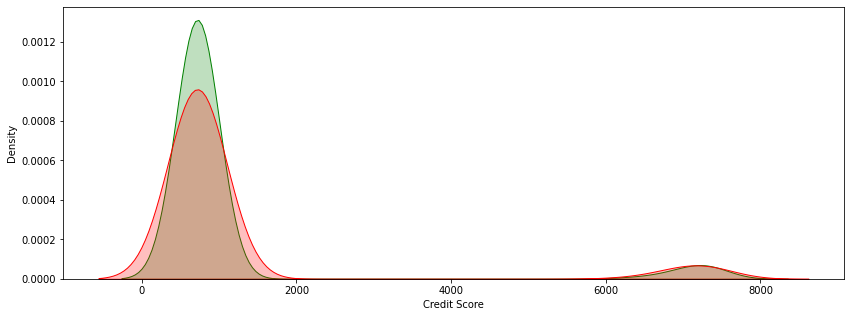

Months since last delinquent


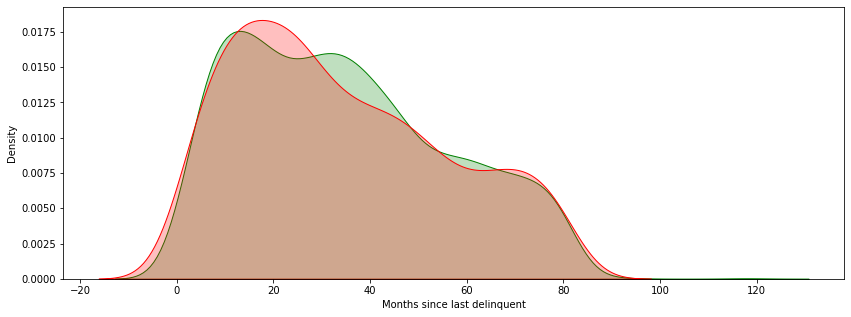

Current Credit Balance


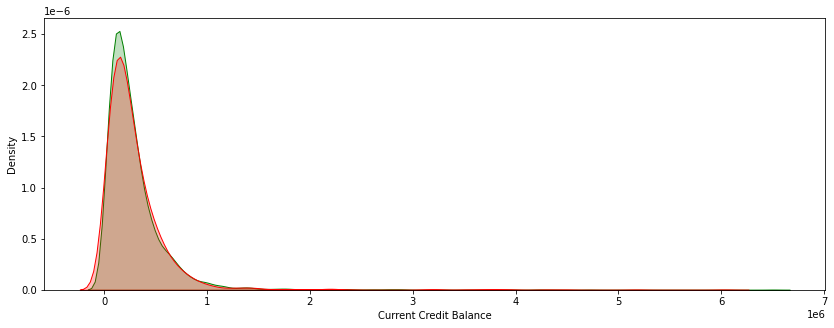

Monthly Debt


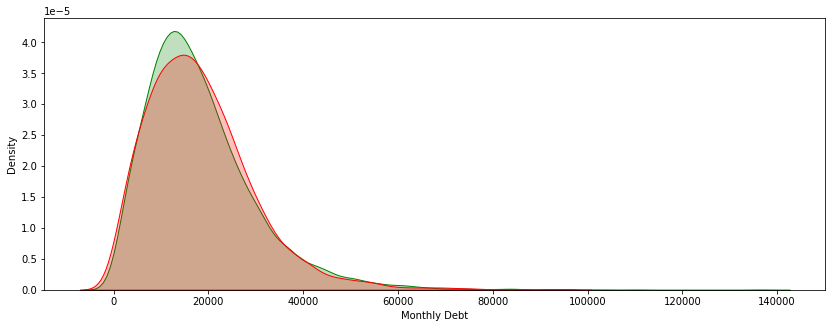

In [703]:
#Рассмотрим распределение на тренировочном и тестовом датасетах
for col in NUM_FEATURE_NAMES:
    print(col)
    plt.figure(figsize = (14,5))
    sns.kdeplot(df_train[col], shade=True,  color='g')
    sns.kdeplot(df_test[col], shade=True, color='r')
    plt.show()

Можно сделать вывод, что в целом распределение большинства количественных признаков на тренировочном и тестовом наборе данных похоже|

In [704]:
for num, column in enumerate(df_train[NUM_FEATURE_NAMES]):
    print(str(num) + ' : ' + str(column) + '\n\n' + str(df_train[column].value_counts()) + '\n' + '-' * 100 + '\n')

0 : Annual Income

1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64
----------------------------------------------------------------------------------------------------

1 : Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
----------------------------------------------------------------------------------------------------

2 : Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      

### Изучим отдельные признаки подробнее

#### Credit Score - наибольшая корреляция с целевой переменной

Этот признак не описан среди заданных, допустим, что он предполагает некую характеристику клиента банка, расчитанную аналитиками на основе неких показателей. Поэтому отнесем его к категориальным

In [705]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64

In [706]:
df_train['Credit Score'].value_counts().count()

268

In [707]:
df_train['Credit Score'].sort_values(ascending = False)

2213    7510.0
3688    7510.0
2408    7500.0
355     7500.0
1363    7490.0
         ...  
7482       NaN
7492       NaN
7494       NaN
7498       NaN
7499       NaN
Name: Credit Score, Length: 7500, dtype: float32

In [708]:
df_train['Credit Score'].isnull().sum()

1557

Поскольку предполагаем, что этот признак - некая расчетная величина, определенная по некоторым признакам клиентов, количество ее значений вполне доступимо может быть большим.

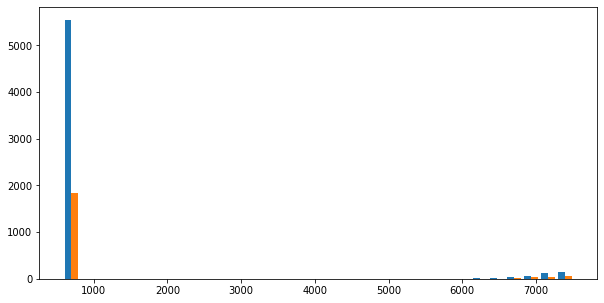

In [709]:
plt.figure(figsize=(10,5))
plt.hist([df_train['Credit Score'], df_test['Credit Score']], bins = 30)
plt.show()

Виден просвет между значениями примерно 700 и 6000, после чего идет длинный "хвост" из явно небольшого количества наблюдений. Расчитаем сколько их и какое значение наибольшее до этого "хвоста"

In [710]:
df_train.loc[df_train['Credit Score'] <=1000, 'Credit Score'].max()

751.0

In [711]:
df_train['Credit Score'].min()

585.0

In [712]:
df_train.loc[df_train['Credit Score'] >= 1000, 'Credit Score'].count()

400

Значений хвоста немного, но их распределение на трейне и тесте похоже, поэтому предположим, что это не выброс, и эта отличительная характеристика может быть полезна при обучении. При наибольшей корреляционной связи с таргетом, эти значения могут оказать важное влияние на точность модели

Оставшиеся значения распределены в промежутке между 585 и 751 (относительно генеральной совокупность этот интервал маленький) -> вполне допустимо заполнить пропуски медианой

In [713]:
df_train['Credit Score'].isnull().sum() #должен быть 0 после заполнения пропусков

1557

#### Annual Income - Годовой доход

In [714]:
df_train['Annual Income'].isnull().sum()

1557

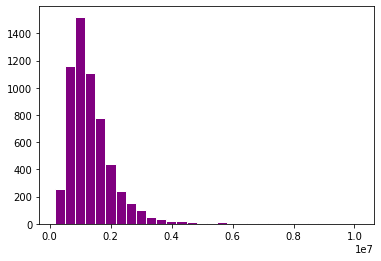

In [715]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(df_train['Annual Income'], bins = 30, color = 'purple', ec = 'white')

plt.show()

Доход - очень индивидуальный признак, повторяющихся значений очевидно мало, в данном случае все его значения можно допустить и не причислять к выбросам

In [716]:
#Вариант 1. 
# Добавляем признак о неизвестном доходе и присваиваю всем наблюдениям 0
#df_train['Unknown Income'] = 0
# Всем, у кого неизвестна зарплата делаем пометку "1" в столбец unknown_income
#df_train.loc[(df_train['Annual Income'].isnull()), 'Unknown Income'] = 1

# Вариант 2

#train_df["Annual Income"] = train_df["Annual Income"].fillna(train_df["Annual Income"].median(), inplace = True)



#### Current Loan Amount - Текущий кредитный баланс

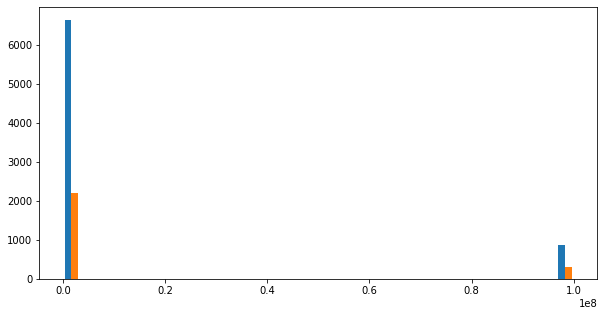

In [717]:
plt.figure(figsize=(10,5))
plt.hist([df_train['Current Loan Amount'], df_test['Current Loan Amount']], bins = 30)
plt.show()

In [718]:
df_train['Current Loan Amount'].value_counts()

100000000.0    870
89298.0          6
218064.0         6
216106.0         5
265826.0         5
              ... 
222860.0         1
104324.0         1
201080.0         1
427812.0         1
191136.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [719]:
df_train['Current Loan Amount'].max()

100000000.0

In [720]:
df_train.loc[df_train['Current Loan Amount'] == 100000000, 'Current Loan Amount'].count()

870

In [721]:
df_train['Current Loan Amount'].isnull().sum()

0

Значение 100000000.0 будем считать выбросом. Далее рассмотрим, как лучше всего его обработать

Можно допустить, что это не выброс, а только взятые кредиты, но такое большое количество одинаковых значений выглядит странно. Рассмотрим разные варианты работы с этим признаком

In [722]:
# Заменим отличительно большие значения признака (выбросы), определенные выше, на среднее значение
#df_train.loc[df_train["Current Loan Amount"] > 1000000, "Current Loan Amount"] = df_train.loc[df_train["Current Loan Amount"] <= 1000000, "Current Loan Amount"].mean()

In [723]:
df_train['Current Loan Amount'].max()

100000000.0

#### Months since last delinquent - Количество месяцев с последней просрочки платежа

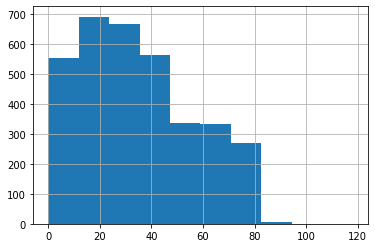

In [724]:
df_train['Months since last delinquent'].hist()
plt.show()

In [725]:
df_train['Months since last delinquent'].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
19.0     65
         ..
84.0      1
86.0      1
91.0      1
118.0     1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [726]:
df_train['Months since last delinquent'].isnull().sum()

4081

У признака Months since last delinquent очень низкая корреляция с целевой переменной, возможно имеет смысл его удалить и не использовать в построении итоговой модели

In [727]:
#df_train.drop(columns = 'Months since last delinquent', axis = 1, inplace = True) - удаление

#### Months since last delinquent - Количество месяцев с последней просрочки платежа

Самое большое количество пропусков - более 50%!

In [728]:
df_train['Months since last delinquent'].isnull().sum()

4081

In [729]:
df_train['Months since last delinquent'].min()

0.0

In [730]:
df_train.loc[df_train['Months since last delinquent'] == 0, 'Months since last delinquent'].count()

18

Предположим, что пропуски в данном случае неслучайны и они обозначают, что просрочки платежа нет. Поэтому заменим. NaN на 0.

В данном случае следует добавить бинарный признак, показывающий наличие или отсутствие задолженности (0 - значение признака 0, 1-значения признака, отличные от 0)

#### Credit Score

Этот признак не описан среди заданных, допустим, что он предполагает некую характеристику клиента банка, расчитанную аналитиками на основе неких показателей. Поэтому отнесем его к категориальным

In [731]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64

In [732]:
df_train['Credit Score'].value_counts().count()

268

In [733]:
df_train['Credit Score'].sort_values(ascending = False)

2213    7510.0
3688    7510.0
2408    7500.0
355     7500.0
1363    7490.0
         ...  
7482       NaN
7492       NaN
7494       NaN
7498       NaN
7499       NaN
Name: Credit Score, Length: 7500, dtype: float32

In [734]:
df_train['Credit Score'].isnull().sum()

1557

Поскольку предполагаем, что этот признак - некая расчетная величина, определенная по некоторым признакам клиентов, количество ее значений вполне доступимо может быть большим.

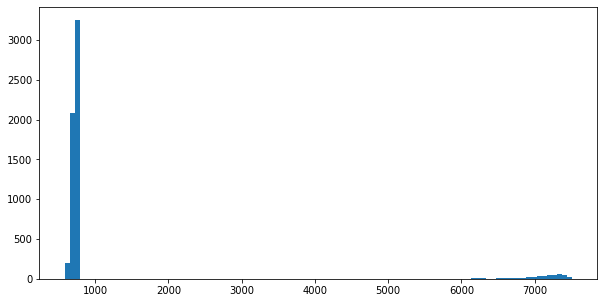

In [735]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
ax.hist(df_train['Credit Score'], bins = 100)
plt.show()

Виден просвет между значениями примерно 700 и 6000, после чего идет длинный "хвост" из явно небольшого количества наблюдений. Расчитаем сколько их и какое значение наибольшее до этого "хвоста"

In [736]:
df_train.loc[df_train['Credit Score'] <=1000, 'Credit Score'].max()

751.0

In [737]:
df_train['Credit Score'].min()

585.0

In [738]:
df_train.loc[df_train['Credit Score'] >= 1000, 'Credit Score'].count()

400

Значений хвоста немного, но их распределение на трейне и тесте похоже, поэтому предположим, что это не выброс, и эта отличительная характеристика может быть полезна при обучении.

Оставшиеся значения распределены в промежутке между 585 и 751 (относительно генеральной совокупность этот интервал маленький) -> вполне допустимо заполнить пропуски медианой

In [739]:
df_train['Credit Score'].isnull().sum() #должен быть 0 после заполнения пропусков

1557

**Поскольку у признака Credit Score большое количество пропусков и очевидно, что он будет важен для модели, создадим дополнительный признак метку, где обозначим клиентов, у которых не был это показатель известен - unknown_credit_score**

### Категориальные признаки

**Изучим распределение категориальных признаков на тренировочном и тестовом наборах данных в зависимости от разных признаков (num_feature)**

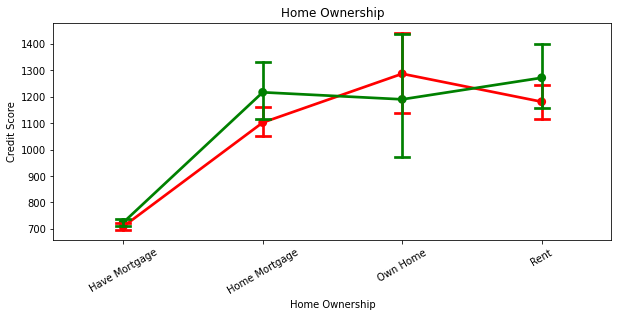

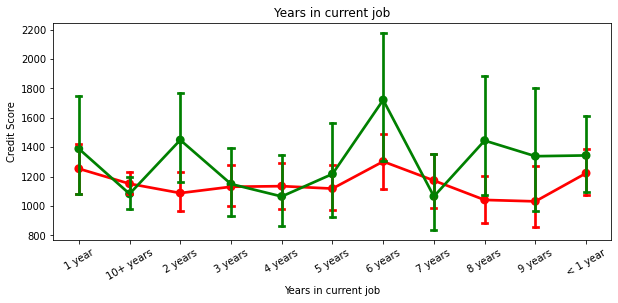

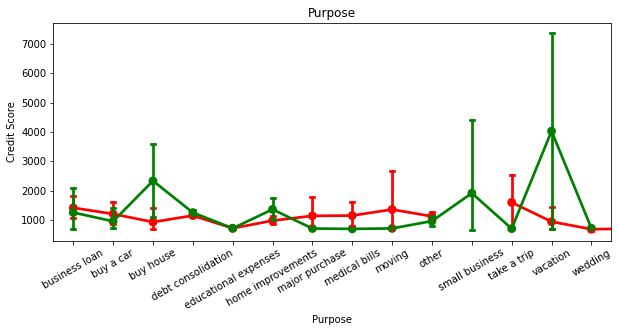

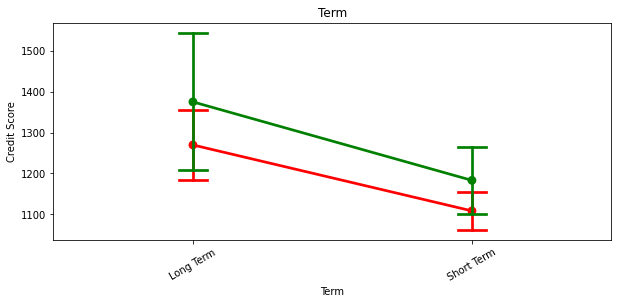

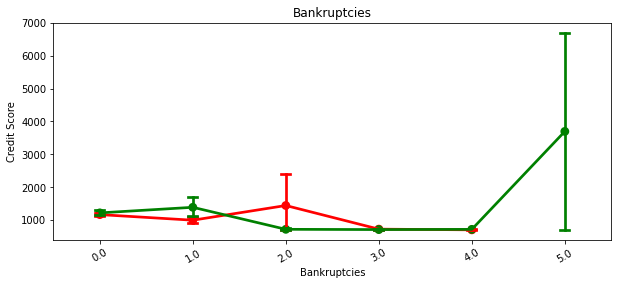

In [740]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=(10,4))
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.xticks(rotation=30) 
    plt.title(col)
    plt.show()

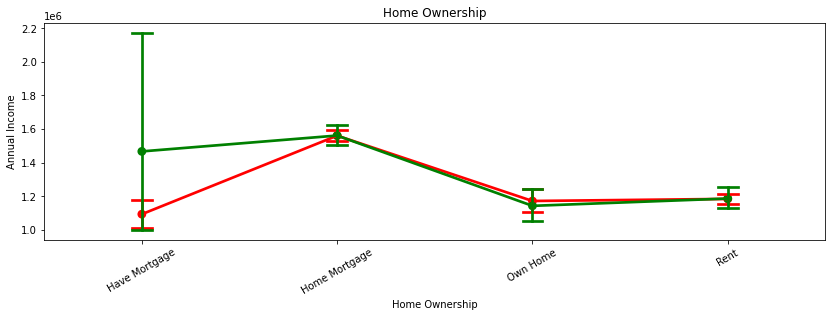

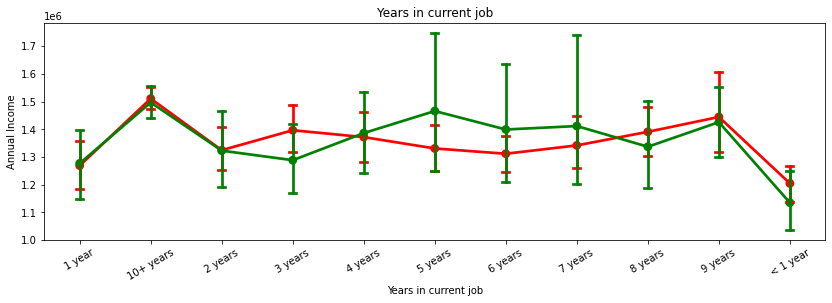

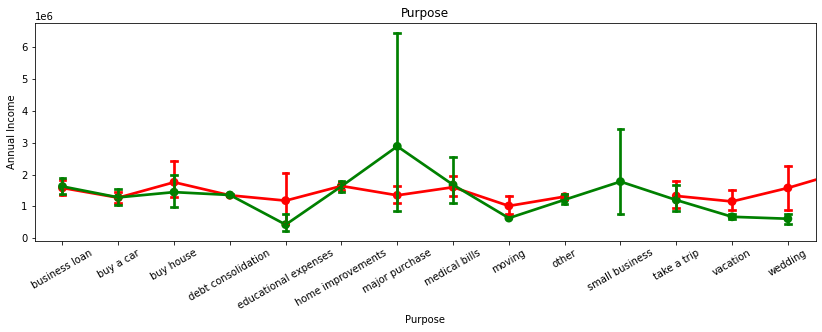

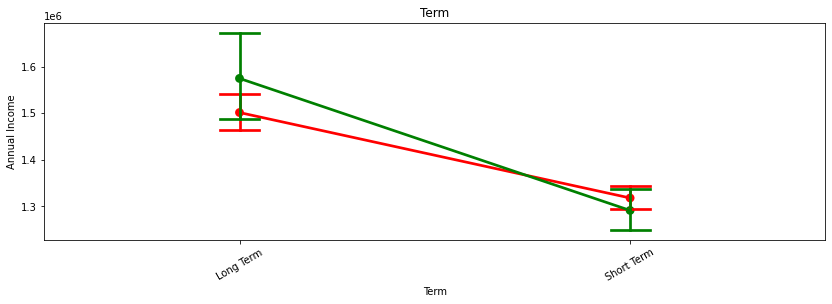

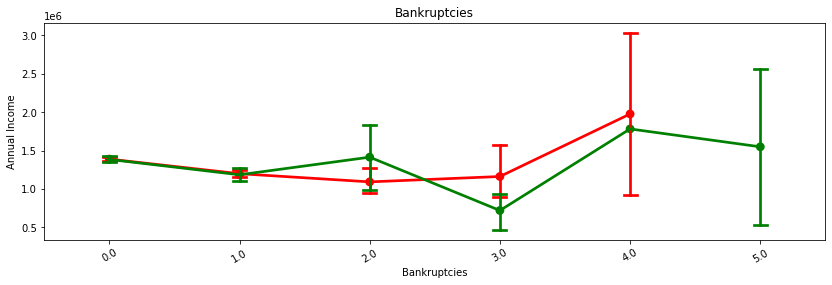

In [755]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=(14,4))
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.xticks(rotation=30) 
    plt.title(col)
    plt.show()

#### Years in Current Job

In [742]:
years_job = df_train['Years in current job'].value_counts()

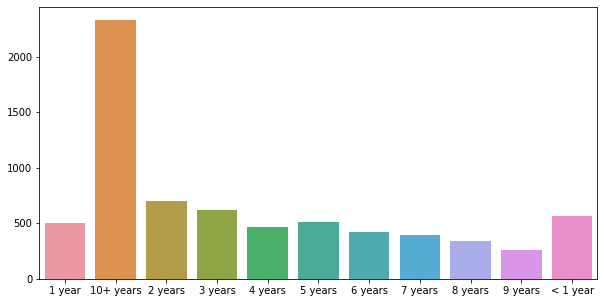

In [743]:
plt.figure(figsize = (10,5))
sns.barplot(years_job.index, years_job.values)
plt.show()

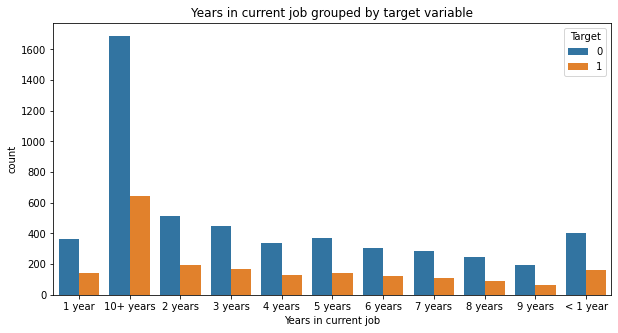

In [744]:
plt.figure(figsize = (10,5))

sns.countplot(x=df_train["Years in current job"], hue=df_train[TARGET_NAME], data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [745]:
# Не забудем, что у признака были найдены пропуски
df_train['Years in current job'].isnull().sum()

371

Значений признака относительно много, а пропусков довольно мало, попробуем заполнить их рандомными значениями из имеющихся в признаке.

In [746]:
list(df_train['Years in current job'].unique())

[nan,
 '10+ years',
 '8 years',
 '6 years',
 '7 years',
 '5 years',
 '1 year',
 '< 1 year',
 '4 years',
 '3 years',
 '2 years',
 '9 years']

In [747]:
list(df_test['Years in current job'].unique())

['4 years',
 '1 year',
 '3 years',
 '10+ years',
 '6 years',
 '5 years',
 '< 1 year',
 '2 years',
 '9 years',
 '8 years',
 '7 years',
 nan]

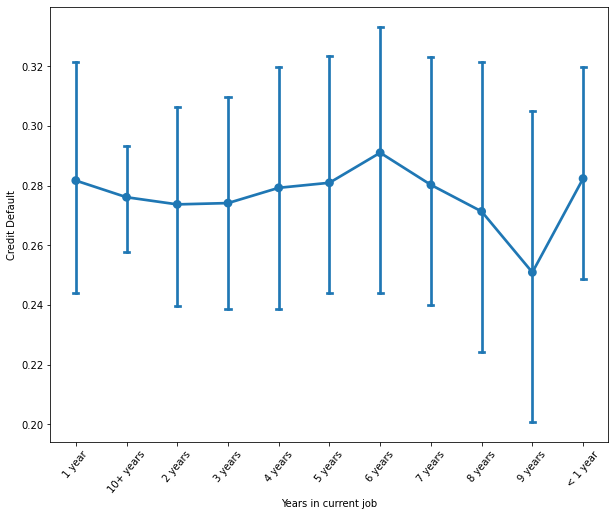

In [825]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Years in current job', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

In [ ]:

'''df['experience_cat'] = 0
df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = 0
df.loc[df['Years in current job'] == '1 year', 'Years in current job'] = 1
df.loc[df['Years in current job'] == '2 years', 'Years in current job'] = 2
df.loc[df['Years in current job'] == '3 years', 'Years in current job'] = 3
df.loc[df['Years in current job'] == '4 years', 'Years in current job'] = 
df.loc[df['Years in current job'] == '5 years', 'Years in current job'] = 5
df.loc[df['Years in current job'] == '6 years', 'age_cat'] = 6
df.loc[df['Years in current job'] == '7 years', 'age_cat'] = 7
df.loc[df['Years in current job'] == '5 years', 'age_cat'] = 8
df.loc[df['Years in current job'] == '6 years', 'age_cat'] = 9
df.loc[df['Years in current job'] == '7 years', 'age_cat'] = 10
df.loc[df['Years in current job'] == '8 years', 'age_cat'] = 11
df.loc[df['Years in current job'] == '9 years', 'age_cat'] = 12
df.loc[df['Years in current job'] == '10+ years', 'age_cat'] = 13
#df = df.drop('Years in current job', axis = 1)
'''

#### Purpose - цель кредита

In [748]:
purpose_values = df_train['Purpose'].value_counts()

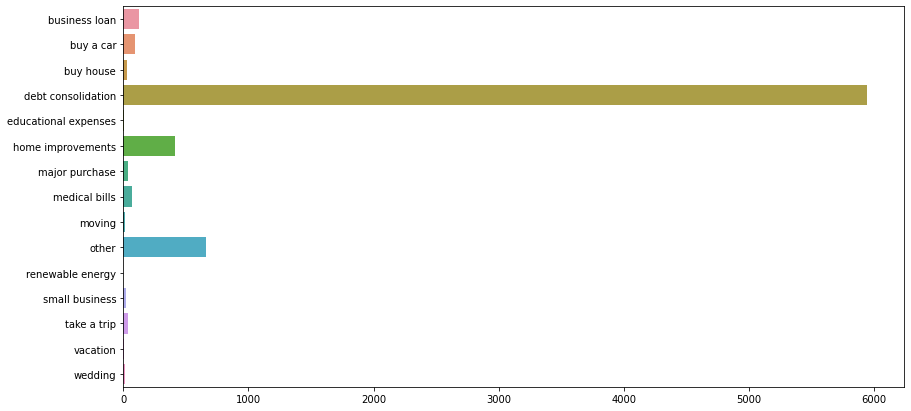

In [749]:
plt.figure(figsize = (14,7))
sns.barplot(purpose_values.values, purpose_values.index)
plt.show()

In [750]:
df_train.loc[df_train['Purpose'] == 'debt consolidation', 'Purpose'].count()

5944

In [762]:
df_train.loc[df_train['Purpose']=='renewable energy', 'Purpose'].count()

2

In [761]:
df_test.loc[df_test['Purpose']=='renewable energy', 'Purpose'].count()

0

In [763]:
#однозначно категорию renewable energy убираем
df_train.loc[df_train['Purpose']=='renewable energy', 'Purpose'] = 'debt consolidation'

In [767]:
list(df_train['Purpose'].unique())

['debt consolidation',
 'other',
 'home improvements',
 'take a trip',
 'buy a car',
 'small business',
 'business loan',
 'wedding',
 'educational expenses',
 'buy house',
 'medical bills',
 'moving',
 'major purchase',
 'vacation']

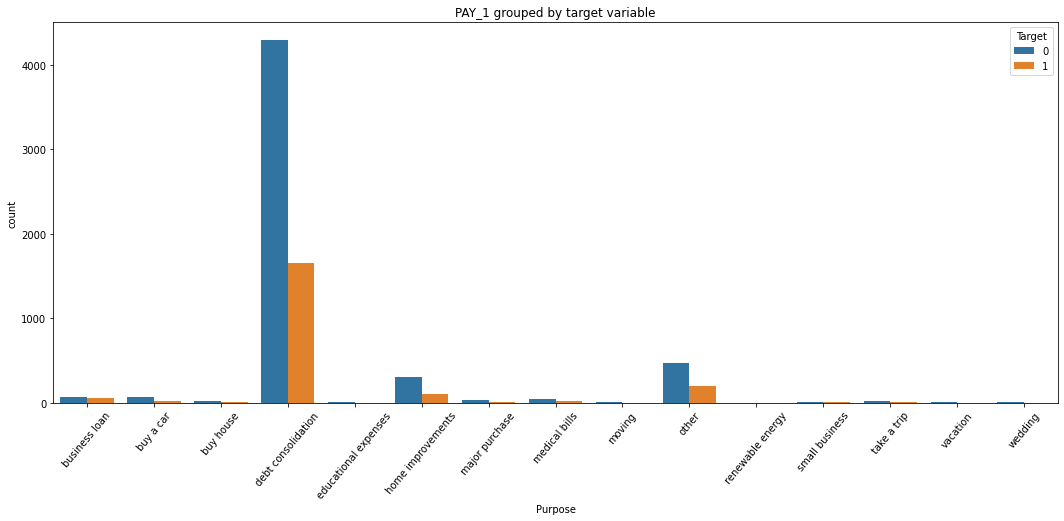

In [768]:
plt.figure(figsize = (18,7))

sns.countplot(x=df_train["Purpose"], hue=df_train[TARGET_NAME], data=df_train)
plt.title('PAY_1 grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.xticks(rotation = 50)

plt.show()

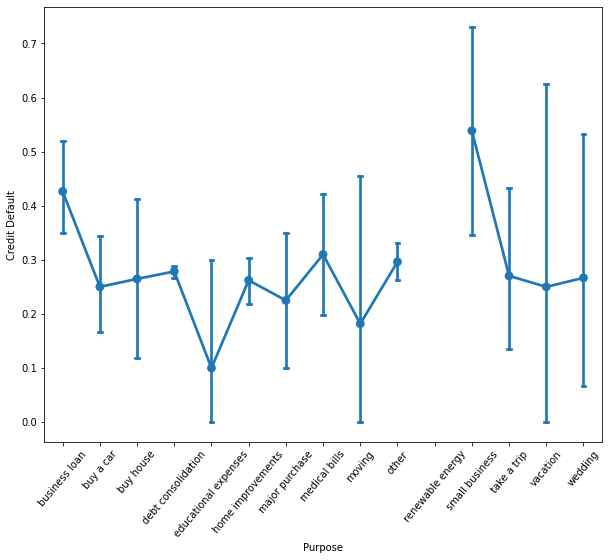

In [769]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Purpose', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

Проверим согласованность частот признаков, имеющих очень маленькие доли в целях изучения возмножности максимального объединения их в один признак

In [775]:
df_train['Purpose'] = df_train['Purpose'].astype('object')

In [815]:
#возьмем за базу для изучения категорию buy house
df_train['Id'] = df_train.index
purpose_and_target = df_train.loc[df_train['Purpose'].isin(['business loan', 'vacation']), ['Id','Credit Default', 
                                                                                         'Purpose']]

In [816]:
table = purpose_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table


Credit Default,0,1
Purpose,,
business loan,74,55
vacation,6,2


In [817]:
chi2, p, _, _ = chi2_contingency(table)
p

0.5402743607872715

Значения p: 
Рассмотрим категории, с похожим распределением с buy house(он находится примерно в середине нижней части графика):
* ['buy house', 'buy a car']  - 0,95
* ['buy house', 'debt consolidation'] - 0.99
* ['buy house', 'educational expenses'] = 0.5 # - не будем объединять
* ['buy house', 'home improvements'] = 0.87
* ['buy house', 'major purchase'] = 0.9
* ['buy house', 'medical bills'] = 0.81
* ['buy house', 'moving'] - 0.88
* ['buy house', 'other'] - 0.84
* ['buy house', 'take a trip'] - 0.83
* ['buy house', 'vacation'] - 0.72
* ['buy house', 'wedding'] - 0.74

Несмотря на то, что с educational expenses p-value получился 0.5 и выше, можно объединить другие категории с мЕньшим риском, а educational expenses оставить отдельно, т.к. он имеет с некоторыми катерииями пограничное значения p-value 

Итого, можно объединить значения:
'buy a car', 'debt condolidation', 'home improvements', 'major purchase', 'medical bills', 'moving' , 'other', 'take a trip', 'vacation', 'wedding' - **все это вместе назовем other и внесем в код для преобразования признаков**

In [599]:
#df_train.loc[df_train['Purpose'].isin(['buy a car', 'debt condolidation', 'home improvements', 'major purchase', 
#                                   'medical bills', 'moving' , 'other', 'take a trip', 'vacation', 'wedding' ]),
#                                   'Purpose'] = 'other'

In [605]:
df_train['Purpose'].unique()

array(['other', 'small business', 'business loan', 'educational expenses'],
      dtype=object)

In [603]:
#df_test.loc[df_test'Purpose'].isin(['buy a car', 'debt condolidation', 'home improvements', 'major purchase', 
#                                   'medical bills', 'moving' , 'other', 'take a trip', 'vacation', 'wedding' ]),
#                                   'Purpose'] = 'other'

In [604]:
#df_test['Purpose'].nunique()

4

#### Home Ownership   - домовладение         

In [123]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Предположим, что Have Mortgage - выброс, возникший в результате опечатки и заменим 12 значений на Home Mortgage

In [124]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

#### Bankruptcies   - банкротства         

In [57]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [461]:
df_train['Bankruptcies'].isnull().sum()

14

Видимо, значение признака предполагает количество банкротств юр. лиц , зарегистрированных на клиента. Т.к. обычно бОльшая часть население не имеет зарегистрированных на себя фирм, то значение 0 преобладает. Однако есть клиенты, кто видимо неоднократно пытался начать свой бизнес и терпел неудачу, количество таких лиц стремительно сокращается. Допускаю, что значения признака адекватны в данном случае.

Пропуски имеет смысл заполнить нулями, пропусков мало и это допустимо

In [823]:
#на графике выше видно , что значения на трейне и тесте отличаются, изучим подробнее
list(df_train['Bankruptcies'].unique())

[1.0, 0.0, 3.0, nan, 2.0, 4.0]

In [824]:
list(df_test['Bankruptcies'].unique())

[0.0, 1.0, 5.0, nan, 2.0, 3.0, 4.0]

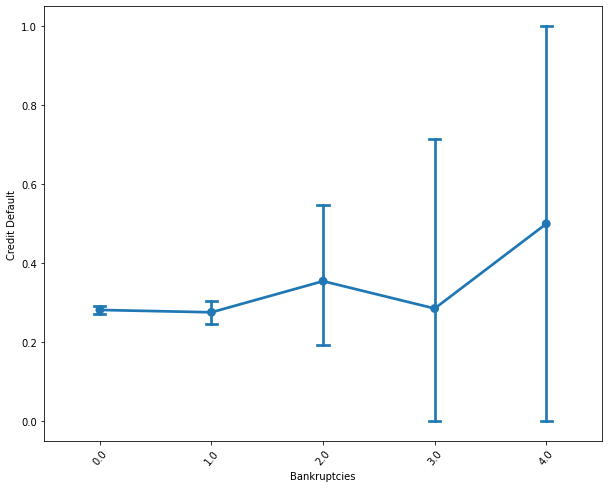

In [819]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Bankruptcies', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

#### Переопределим признаки

#требует корректировки исходя из тех признаков, которые оставим для построения модели

### Разбиение на train и test

In [4078]:
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership',
                    'Term', 'Purpose']

NEW_FEATURE_NAMES = [] # признаки, которые добавились в результате работы с категориями и созданием новых фичей

CAT_FEATURE_NAMES = ['Home Ownership', 'Term', 'Purpose']

# в тотал запишем все признаки для построения модели, включая созданные новые
TOTAL_FEATURE_NAMES = ['Annual Income', 
                        'Tax Liens', 
                        'Number of Open Accounts', 
                        'Years of Credit History', 
                        'Maximum Open Credit',
                        'Number of Credit Problems',
                        'Current Loan Amount', 
                        'Current Credit Balance', 
                        'Monthly Debt', 
                        'Credit Score', 
                        'Home Ownership',
                        'Term', 
                        'Purpose'
                       #дополнительные признаки
                       
                       
                       ]



In [ ]:
X = df_train[total_feature_names]
y = df_train[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 42)

 ## Обработка признаков -  Feature Engineering  

**Python код для преобразования данных** -  в процессе формирования...

In [ ]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.annual_income_median = None
        self.current_loan_am_mean = None
        self.credit_score_median = None
        self.var_years_in_current_job = None
        sefl.years_unique = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет статистик
        self.annual_income_median = df['Annual Income'].median()
        self.current_loan_am_mean = df['Current Loan Amount'].mean()
        self.credit_score_median = df['Credit Score'].median()
        sefl.years_unique = df['Years in current job'].unique()[1:]

    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        
        df['Annual Income'].fillna(self.annual_income_median, inplace=True)
        df['Credit Score'].fillna(self.credit_score_median, inplace = True)
        df['Months since last delinquent'].fillna(0, inplace=True)
        df['Years in current job'].fillna(random.choice(self.years_unique), inplace=True)
        df['Bankruptcies'].fillna(0 , inplace=True)
        
        
        # 2. Выбросы (outliers)
        
        df.loc[df["Current Loan Amount"] > 1000000, "Current Loan Amount"] = /
        / df.loc[df["Current Loan Amount"] <= 1000000, "Current Loan Amount"].mean()
        
        # 3. Новые фичи (features) - добавим 2 новых признака
        
        # 1) Бинарный признак о наличии задолженности на основе признака Months since last delinquent - has_delay

        df['has_delay'] = 1
        df.loc[(df['Months since last delinquent'] == 0), 'has_delay'] = 0
        
        # 2) Признак - метка о неизвестном Credit Score - unknown_credit_score
        
        df['unknown_credit_score'] = 0
        df.loc[(df['Credit Score'].isnull()), 'unknown_credit_score'] = 1
        
        # 3) Доля дохода клиента, которая уходит на кредит - part_of_income_for_credit
        
        df['part_of_income_for_credit'] = df['Monthly Debt']*12/df['Annual Income']
        
        # 4) Количество оставшихся месяцев выплаты кредита - months_of_payments_left
        
        df['months_of_payments_left'] = math.ceil(df['Current Loan Amount']/df['Monthly Debt'])
        
        
        
        # 4. Обработка категорий 
        
        df.loc[df['Purpose'].isin(['buy a car', 'debt condolidation', 'home improvements', 'major purchase', 
                                   'medical bills', 'moving' , 'other', 'take a trip', 'vacation', 'wedding' ]),
                                   'Purpose'] = 'other'
        
        #перевод в дамми
        
        #for cat_colname in CAT_FEATURE_NAMES:
             #   df = pd.concat([df, pd.get_dummies(df[cat_colname])], axis=1)
        
        return df

In [ ]:
pipe = DataPipeline()
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
df_test = pipe.transform(df_test)

### Стандартизация данных -  на X_train


In [4085]:
scaler = StandardScaler()

X_norm = X_train.copy()
X_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(X_norm[NUM_FEATURE_NAMES])

X_train = X_norm.copy()

#### Переопределим признаки

#требует корректировки исходя из тех признаков, которые оставим для построения модели

In [4078]:
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership',
                    'Term', 'Purpose']

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Term', 'Purpose']

In [4086]:
X_train.head()

,Home Ownership,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Purpose,Term,Current Loan Amount,...,home improvements,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding
0,Own Home,-1.114304,-0.110953,-0.026674,1.133645,-0.016174,1.664779,debt consolidation,Short Term,8.202912e-08,...,0,0,0,0,0,0,0,0,0,0
1,Own Home,-0.396190,-0.110953,0.788223,-0.428528,0.014763,-0.340979,debt consolidation,Long Term,-2.570651e-01,...,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,-0.758385,-0.110953,-0.026674,2.369181,0.014807,-0.340979,debt consolidation,Short Term,8.202912e-08,...,0,0,0,0,0,0,0,0,0,0
3,Own Home,-0.687478,-0.110953,-0.637847,0.593985,-0.049781,1.664779,debt consolidation,Short Term,-1.094795e+00,...,0,0,0,0,0,0,0,0,0,0
4,Rent,-0.725543,-0.110953,0.380774,-0.669954,-0.034903,1.664779,debt consolidation,Short Term,-1.068865e+00,...,0,0,0,0,0,0,0,0,0,0


In [53]:
#добавим разделение на трейн и тест

Видимо, значение признака предполагает количество банкротств юр. лиц , зарегистрированных на клиента. Т.к. обычно бОльшая часть население не имеет зарегистрированных на себя фирм, то значение 0 преобладает. Однако есть клиенты, кто видимо неоднократно пытался начать свой бизнес и терпел неудачу, количество таких лиц стремительно сокращается. Допускаю, что значения признака адекватны в данном случае.

In [57]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

#### Bankruptcies   - банкротства         